In [8]:
# ─── Cell 1: Imports & Pretrained Model Setup ─────────────────────────────────
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    T5Tokenizer,
)
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import Dataset as HFDataset, DatasetDict
from PIL import Image
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import json
import cv2
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
from datasets import Dataset

In [ ]:
#***************************************************************Preprocessing***************************************************************#

In [2]:
dataset_path = r"C:\Users\user\Downloads\dataset"  
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    print(f"Class: {folder}, Number of images: {len(os.listdir(folder_path))}")

Class: test, Number of images: 3
Class: train, Number of images: 5


In [3]:
template_path = r"C:\Users\user\Downloads\template"
input_folder = r"C:\Users\user\Downloads\dataset\Bulletin_de_soin"
#output_folder = r"C:\Users\user\Downloads\sizeset\Bulletin_de_soin"

In [4]:
def load_templates_from_folder(folder):
    """
    Load all template images from the specified folder.
    """
    images = {}
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images[filename] = img
    return images

In [5]:
def show_image(image, title="Image"):
    """
    Display an image using matplotlib.
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()

In [6]:
def find_best_template(test_image, templates):
    """Find the best-matching template using SIFT."""
    sift = cv2.SIFT_create()
    keypoints2, descriptors2 = sift.detectAndCompute(test_image, None)
    
    best_match = None
    best_match_count = 0
    best_template_name = None
    
    for filename, template in templates.items():
        keypoints1, descriptors1 = sift.detectAndCompute(template, None)
        if descriptors1 is None or descriptors2 is None:
            continue
        
        flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)
        
        good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
        if len(good_matches) > best_match_count:
            best_match_count = len(good_matches)
            best_match = template
            best_template_name = filename
    
    return best_match, best_template_name

In [7]:
def align_image(test_image, template):
    """Align the test image with the template using SIFT and homography."""
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(template, None)
    keypoints2, descriptors2 = sift.detectAndCompute(test_image, None)
    
    if descriptors1 is None or descriptors2 is None or len(keypoints1) < 10 or len(keypoints2) < 10:
        print("Not enough keypoints for alignment. Using original image.")
        return test_image
    
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    if len(good_matches) >= 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        if H is not None:
            h, w = template.shape
            aligned_image = cv2.warpPerspective(test_image, H, (w, h))
            show_image(aligned_image, "Aligned Image")  # Debugging
            return aligned_image
    print("Alignment failed. Using original image.")
    return test_image

In [8]:
def preprocess_image(image):
    """Preprocess the image with detailed steps and visualizations using Adaptive Thresholding."""
    # 1. Original Image (for reference)
    show_image(image, "Original Image")
    
    # 2. Normalization
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    normalized = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    show_image(normalized, "Normalized Image")
    
    # 3. Image Scaling (to 300 PPI if needed)
    pil_img = Image.fromarray(normalized)
    dpi = 72  
    (h, w) = normalized.shape
    current_ppi = (pil_img.width / (w / dpi)) if w > 0 else 72
    if current_ppi < 300:
        scale_factor = 300 / current_ppi
        new_size = (int(pil_img.width * scale_factor), int(pil_img.height * scale_factor))
        pil_img = pil_img.resize(new_size, Image.Resampling.LANCZOS)
        scaled = np.array(pil_img)
    else:
        scaled = normalized
    show_image(scaled, "Scaled Image (300 PPI)")
    
    # 4. Noise Removal (Gaussian Blur)
    noise_removed = cv2.GaussianBlur(scaled, (5, 5), 0)
    show_image(noise_removed, "Noise Removed Image")
    
    # 5. Thinning and Skeletonization (using erosion)
    kernel = np.ones((5, 5), np.uint8)
    thinned = cv2.erode(noise_removed, kernel, iterations=1)
    show_image(thinned, "Thinned/Eroded Image")
    
    # 6. Thresholding/Binarization (Adaptive Thresholding)
    binary = cv2.adaptiveThreshold(thinned, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 31, 5)
    show_image(binary, "Adaptive Thresholding")
    
    return binary, cv2.cvtColor(thinned, cv2.COLOR_GRAY2BGR)

Best template: 1.jpg


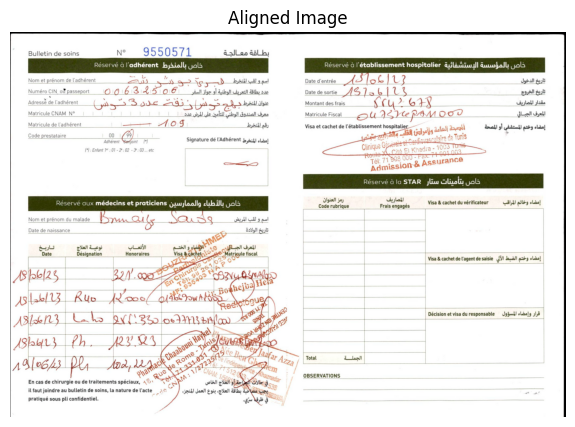

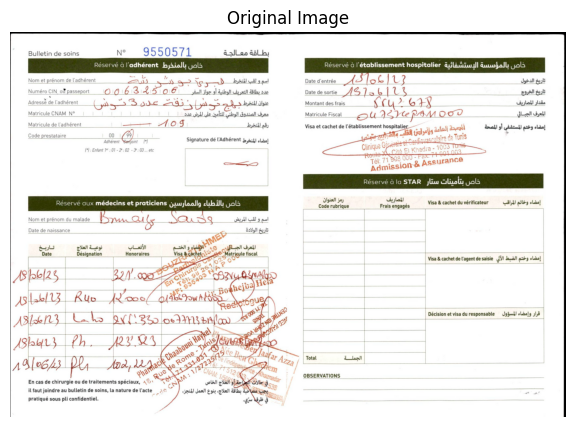

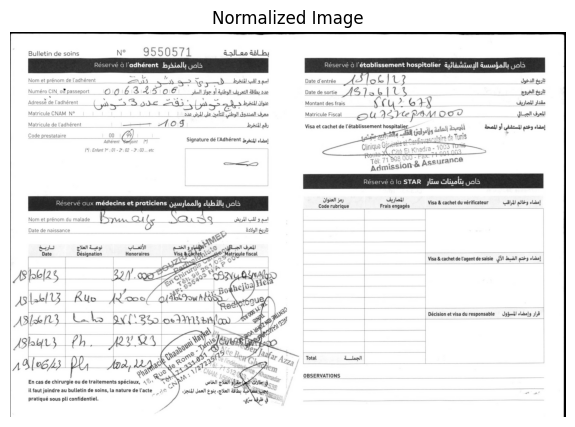

In [ ]:
def main():
    template_folder = r"C:\Users\user\Downloads\template"
    new_image_path = r"C:\Users\user\Downloads\dataset\test\Bulletin_de_soin\0738--9550571--20230705_page_0.jpg"
    templates = load_templates_from_folder(template_folder)
    if not templates:
        print(f"No templates found in '{template_folder}'.")
        return None, None  # Return None if no templates

    new_image = cv2.imread(new_image_path)
    if new_image is None:
        print(f"Could not load image from '{new_image_path}'.")
        return None, None  # Return None if the image can't be loaded
    
    best_match, best_template_name = find_best_template(new_image, templates)
    if best_match is None:
        print("No matching template found.")
        show_image(new_image, "Original Image")
        return None, None  # Return None if no match found
    
    print(f"Best template: {best_template_name}")
    aligned_image = align_image(new_image, best_match)
    
    # Preprocess with Adaptive Thresholding
    binary, original = preprocess_image(aligned_image)
    
    return binary,aligned_image, original  # Return the preprocessed images

# Execute main() and store the results in variables
if __name__ == "__main__":
    binary_image, aligned_image ,original_image = main()
    if binary_image is not None:
        print("Image processing completed.")
    else:
        print("Image processing failed.")


In [ ]:
#***************************************************************DSO***************************************************************#

In [ ]:
images_folder = r"C:\Users\user\Downloads\TrOCR_Data\extracted"
annotations_file = r"C:\Users\user\Downloads\TrOCR_Data\merged_json.json"

with open(annotations_file, 'r', encoding='utf-8') as f:
    annotations_list = json.load(f)

annotations = {
    os.path.basename(item['image_path']): item['text']
    for item in annotations_list
}

data = []

for image_file in os.listdir(images_folder):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(images_folder, image_file)
        label = annotations.get(image_file, None)
        data.append({'image_path': image_path, 'label': label})

df = pd.DataFrame(data)

print(df.head())

In [ ]:
dataset = Dataset.from_pandas(df)
dataset = dataset.rename_columns({"image_path": "image", "label": "text"})

In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

In [ ]:
from PIL import Image
import torch

# Preprocessing function
def preprocess(example):
    try:
        # Skip if text is missing or empty
        if example.get("text") is None or str(example["text"]).strip() == "":
            return None

        # Open and process image
        image = Image.open(example["image"]).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values[0]

        # Tokenize label
        labels = processor.tokenizer(
            example["text"],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        ).input_ids[0]

        # Replace pad token with -100
        labels[labels == processor.tokenizer.pad_token_id] = -100

        return {"pixel_values": pixel_values, "labels": labels}

    except Exception as e:
        print(f"Skipping example due to error: {e}")
        return None
# Apply map with remove_columns and filter afterward
processed_dataset = dataset.map(preprocess, remove_columns=dataset.column_names)

# Remove failed examples (None returns)
processed_dataset = processed_dataset.filter(lambda example: example is not None)


In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
import torch
print("Using GPU:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

class CustomTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        pixel_values = inputs.get("pixel_values")

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        return (loss, outputs) if return_outputs else loss


training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-finetuned",
    per_device_train_batch_size=4,
    num_train_epochs=5,
    logging_steps=10,
    save_steps=500,
    evaluation_strategy="no",
    learning_rate=5e-5,
    save_total_limit=2,
    fp16=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset,
)


trainer.train()

In [ ]:
model.save_pretrained("./trocr-finetuned")
processor.save_pretrained("./trocr-finetuned")

In [9]:
trocr_model = VisionEncoderDecoderModel.from_pretrained("./trocr-finetuned")
trocr_processor = TrOCRProcessor.from_pretrained("./trocr-finetuned")

In [10]:
correction_model_path = "C:/Users/user/Downloads/label_correction_model"
correction_tokenizer = T5Tokenizer.from_pretrained(correction_model_path, use_fast=False)
correction_model = AutoModelForSeq2SeqLM.from_pretrained(correction_model_path)

In [11]:
flant_dir = r"C:\Users\user\Downloads\flan-t5-finetuned"
tokenizer_t5 = T5Tokenizer.from_pretrained(flant_dir)
model_t5     = AutoModelForSeq2SeqLM.from_pretrained(flant_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_t5.to(device)  # Ensure the model is on the same device

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# Charger le modèle YOLOv8
yolo_model = YOLO(r"C:\Users\user\Downloads\train\train\weights\best.pt")


image = cv2.cvtColor(aligned_image , cv2.COLOR_BGR2RGB)  # Conversion pour Matplotlib

# Détection avec un seuil de confiance bas
results = yolo_model(image_path, conf=0.05)

# Paramètres personnalisés pour les boîtes
box_alpha = 0.2  # Transparence du remplissage
line_width = 1    # Épaisseur des contours
font_scale = 0.6  # Taille du texte
text_color = (255, 0, 0)  # Couleur du texte (bleu)
box_color = (0, 255, 0)   # Couleur des boîtes (vert)

# Créer une copie pour l'annotation
annotated_image = image.copy()
# Extraire les coordonnées, scores et classes
boxes = []
scores = []
classes = []

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        boxes.append([x1, y1, x2 - x1, y2 - y1])  # Format [x, y, w, h]
        scores.append(float(box.conf[0]))
        classes.append(int(box.cls))

# Paramètres NMS
nms_threshold = 0.4  # Ajustable
confidence_threshold = 0.2  # Ne garder que les détections pertinentes

# Appliquer NMS
indices = cv2.dnn.NMSBoxes(boxes, scores, confidence_threshold, nms_threshold)
indices = [i[0] if isinstance(i, (list, tuple, np.ndarray)) else i for i in indices]

# Annoter l’image uniquement avec les boîtes gardées
annotated_image = image.copy()

for i in indices:
    x, y, w, h = boxes[i]
    x2, y2 = x + w, y + h
    label = f"{result.names[classes[i]]} {scores[i]:.2f}"

    overlay = annotated_image.copy()
    cv2.rectangle(overlay, (x, y), (x2, y2), box_color, -1)
    annotated_image = cv2.addWeighted(overlay, box_alpha, annotated_image, 1 - box_alpha, 0)
    cv2.rectangle(annotated_image, (x, y), (x2, y2), box_color, line_width)
    cv2.putText(annotated_image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, 1)


# Affichage
plt.figure(figsize=(12, 10))
plt.imshow(annotated_image)
plt.axis("off")
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()  # Coordonnées (xmin, ymin, xmax, ymax)
    labels = result.boxes.cls.cpu().numpy().astype(int)  # Indices des classes
    scores = result.boxes.conf.cpu().numpy()  # Confiances
    
    for i, box in enumerate(result.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        image_pil = Image.fromarray(image)
        cropped = image_pil.crop((x1, y1, x2, y2))
    
        if np.array(cropped).size == 0:
            continue
    
        # Préparation pour TrOCR
        inputs = trocr_processor(images=cropped, return_tensors="pt").pixel_values
        inputs = inputs.to(trocr_model.device)
    
        with torch.no_grad():
            output = trocr_model.generate(inputs)
            text = trocr_processor.batch_decode(output, skip_special_tokens=True)[0]  # ← Move inside
    
        # Affichage avec OCR spécifique à chaque box
        cropped_img = image[y1:y2, x1:x2]
        plt.figure(figsize=(4, 4))
        plt.imshow(cropped_img)
   

        if yolo_model.names[classes[i]] == "designation":
            inputs_t5 = tokenizer_t5(text, return_tensors="pt").to(device)
            with torch.no_grad():
                ids_t5 = model_t5.generate(inputs_t5["input_ids"], max_length=50)
            meaning = tokenizer_t5.decode(ids_t5[0], skip_special_tokens=True)
            combined_text = (
                f'OCR Output: {text} - '
                f'Class: {yolo_model.names[classes[i]]} - '
                f'Designation: {meaning} '
            )
        else:
            combined_text = (
                f'OCR Output: {text} - '
                f'Class: {yolo_model.names[classes[i]]} '
            )


        
        plt.title(combined_text, fontsize=12, pad=20)
        plt.axis('off')
        plt.show()

# Enregistrer le résultat si besoin
output_path = "detection_result1.jpg"
cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
print(f"Résultat sauvegardé sous : {output_path}")

plt.show()

In [ ]:
from transformers import pipeline, set_seed

# Load a free GPT-2 based model
generator = pipeline('text-generation', model='distilgpt2')
set_seed(42)

# Basic chatbot loop
print("Medical Insurance Chatbot (Offline - Simple GPT-2)\nType 'exit' to stop.\n")

while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break
    
    # Generate a response
    response = generator(f"Patient asks: {user_input}\nAnswer:", max_length=100, num_return_sequences=1)
    print("Bot:", response[0]['generated_text'].split("Answer:")[-1].strip())


In [12]:
from difflib import get_close_matches
from spellchecker import SpellChecker
from transformers import T5Tokenizer, T5ForConditionalGeneration
import re

# Define correction functions once
french_months = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 
                 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']
spell = SpellChecker(language='fr')

def correct_date(text):
    parts = re.findall(r'\d{1,2}|[a-zA-Zéûî]+|\d{4}', text)
    corrected = []
    for part in parts:
        if part.isdigit():
            corrected.append(part)
        else:
            match = get_close_matches(part.lower(), french_months, n=1, cutoff=0.6)
            corrected.append(match[0] if match else part)
    return ' '.join(corrected)




image 1/1 C:\Users\user\Downloads\dataset\test\Bulletin_de_soin\3762--9425234--20230914_page_0.jpg: 448x640 1 CIN, 1 ID, 2 adresses, 6 datestars, 1 designation, 8 honorairestars, 1 matriculeadherant, 1 nom et prenom, 1 nomprenomadherant, 66.6ms
Speed: 4.7ms preprocess, 66.6ms inference, 3.2ms postprocess per image at shape (1, 3, 448, 640)


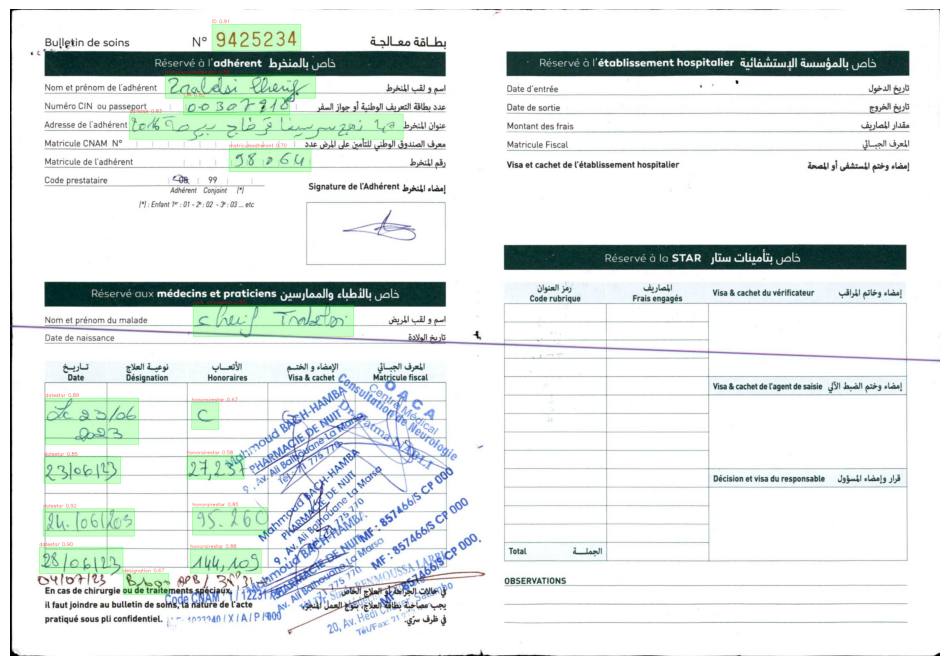

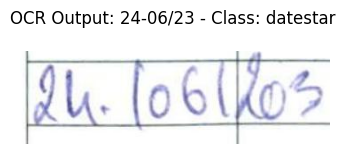

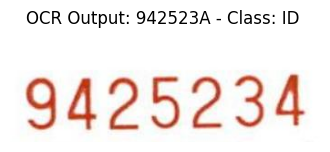

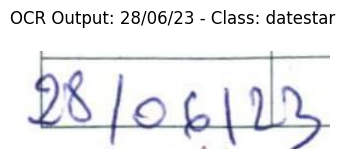

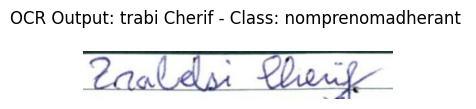

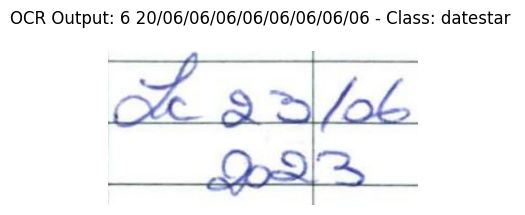

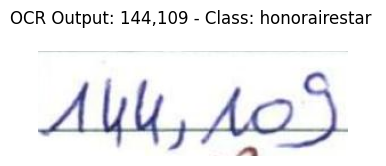

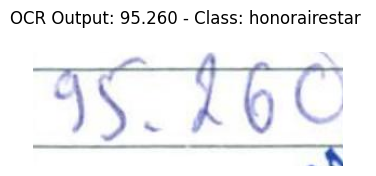

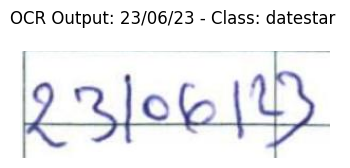

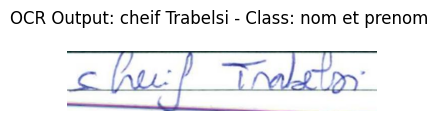

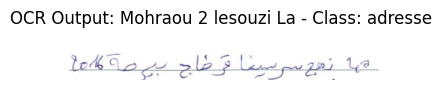

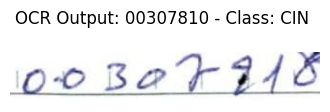

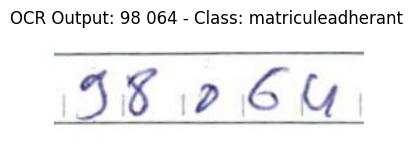

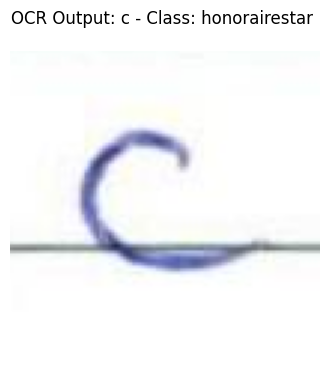

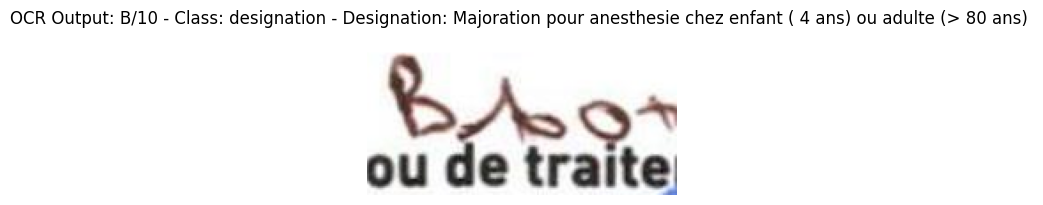

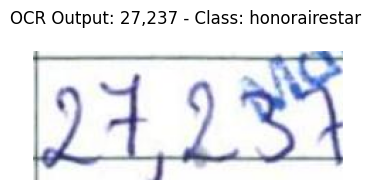

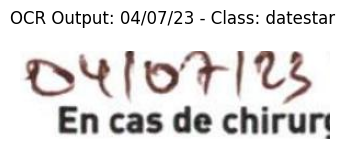

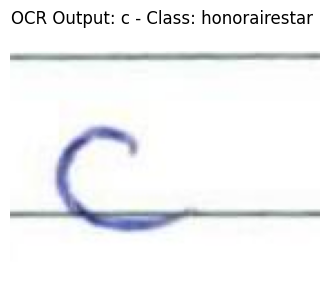

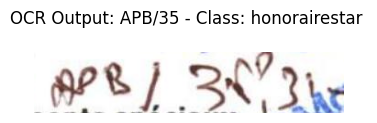

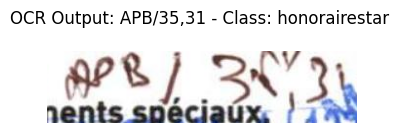

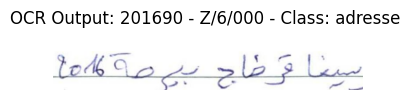

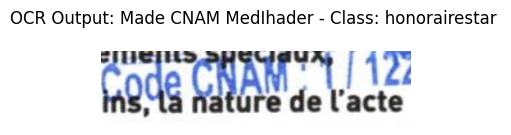

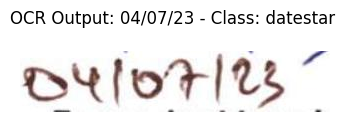

Résultat sauvegardé sous : detection_result1.jpg


In [27]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

yolo_model = YOLO(r"C:\Users\user\Downloads\train\train\weights\best.pt")

image_path = r"C:\Users\user\Downloads\dataset\test\Bulletin_de_soin\3762--9425234--20230914_page_0.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

results = yolo_model(image_path, conf=0.05)

box_alpha = 0.2  
line_width = 1    
font_scale = 0.6 
text_color = (255, 0, 0)  
box_color = (0, 255, 0)  

annotated_image = image.copy()
boxes = []
scores = []
classes = []

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        boxes.append([x1, y1, x2 - x1, y2 - y1]) 
        scores.append(float(box.conf[0]))
        classes.append(int(box.cls))
nms_threshold = 0.4 
confidence_threshold = 0.2  
indices = cv2.dnn.NMSBoxes(boxes, scores, confidence_threshold, nms_threshold)
indices = [i[0] if isinstance(i, (list, tuple, np.ndarray)) else i for i in indices]
annotated_image = image.copy()
for i in indices:
    x, y, w, h = boxes[i]
    x2, y2 = x + w, y + h
    label = f"{result.names[classes[i]]} {scores[i]:.2f}"
    overlay = annotated_image.copy()
    cv2.rectangle(overlay, (x, y), (x2, y2), box_color, -1)
    annotated_image = cv2.addWeighted(overlay, box_alpha, annotated_image, 1 - box_alpha, 0)
    cv2.rectangle(annotated_image, (x, y), (x2, y2), box_color, line_width)
    cv2.putText(annotated_image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, 1)

# Affichage
plt.figure(figsize=(12, 10))
plt.imshow(annotated_image)
plt.axis("off")
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()  # Coordonnées (xmin, ymin, xmax, ymax)
    labels = result.boxes.cls.cpu().numpy().astype(int)  # Indices des classes
    scores = result.boxes.conf.cpu().numpy()  # Confiances
    
    for i, box in enumerate(result.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        image_pil = Image.fromarray(image)
        cropped = image_pil.crop((x1, y1, x2, y2))
    
        if np.array(cropped).size == 0:
            continue
    
        # Préparation pour TrOCR
        inputs = trocr_processor(images=cropped, return_tensors="pt").pixel_values
        inputs = inputs.to(trocr_model.device)
    
        with torch.no_grad():
            output = trocr_model.generate(inputs)
            text = trocr_processor.batch_decode(output, skip_special_tokens=True)[0]  # ← Move inside
    
        # Affichage avec OCR spécifique à chaque box
        cropped_img = image[y1:y2, x1:x2]
        plt.figure(figsize=(4, 4))
        plt.imshow(cropped_img)
   

        if yolo_model.names[classes[i]] == "designation":
            inputs_t5 = tokenizer_t5(text, return_tensors="pt").to(device)
            with torch.no_grad():
                ids_t5 = model_t5.generate(inputs_t5["input_ids"], max_length=50)
            meaning = tokenizer_t5.decode(ids_t5[0], skip_special_tokens=True)
            combined_text = (
                f'OCR Output: {text} - '
                f'Class: {yolo_model.names[classes[i]]} - '
                f'Designation: {meaning} '
            )
        else:
            label_class = yolo_model.names[classes[i]]
            
            if label_class == "datedenaissancestar":
                corrected_text = correct_date(text)
            else:
                corrected_text = text

            combined_text = (
                f'OCR Output: {corrected_text} - '
                f'Class: {label_class} '
            )


        
        plt.title(combined_text, fontsize=12, pad=20)
        plt.axis('off')
        plt.show()

# Enregistrer le résultat si besoin
output_path = "detection_result1.jpg"
cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
print(f"Résultat sauvegardé sous : {output_path}")

plt.show()